# Investigating FB ad.id

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

import datautil as du
from analysis_util_01 import MMM, MMMChannelsStraight, MMMChannelsStraightConfounder, MMMFbGoogleMetrics

%load_ext autoreload
%autoreload 2

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
facebook = du.get_engineered_file('facebook')

## Distribution of conversion rates

In [3]:
facebook.head()

,date,ad_id,spend,reach,impressions,clicks,purchases,purchases_value,roas,ctr,cost_per_purchase,ad_id_date_first,ad_id_days_since_first_seen
0,2024-05-19,120202188355420590,35.71,1030,1116,46,0,0.00,0.000000,0.041219,NaN,2024-01-05,135
1,2024-05-19,120202188650350590,20.43,5463,5852,101,0,0.00,0.000000,0.017259,NaN,2024-01-22,118
2,2024-05-19,120202188650420590,41.88,7163,8141,188,0,0.00,0.000000,0.023093,NaN,2024-01-22,118
3,2024-05-19,120203048518460590,100.54,1619,1715,52,0,0.00,0.000000,0.030321,NaN,2024-01-30,110
4,2024-05-19,120204688537830590,216.71,3772,4452,198,1,165.68,0.764524,0.044474,216.71,2024-03-08,72


In [4]:
conv_rates = facebook.copy()
# group by ad_id and sum the conversions
conv_rates = conv_rates.groupby('ad_id')[['impressions', 'clicks', 'purchases']].sum().reset_index() 
conv_rates['cr_imp_click'] = conv_rates['clicks'] / conv_rates['impressions']
conv_rates['cr_click_purchase'] = conv_rates['purchases'] / conv_rates['clicks']
conv_rates['cr_imp_purchase'] = conv_rates['purchases'] / conv_rates['impressions']
conv_rates.head(20)

,ad_id,impressions,clicks,purchases,cr_imp_click,cr_click_purchase,cr_imp_purchase
0,23849013860970589,6898,80,1,0.011598,0.012500,0.000145
1,23849013861000589,3974,58,0,0.014595,0.000000,0.000000
2,23849013861020589,32063,146,0,0.004554,0.000000,0.000000
3,23849013861040589,4345,62,1,0.014269,0.016129,0.000230
4,23849013959450589,32856,319,2,0.009709,0.006270,0.000061
5,23849013981520589,9073,125,1,0.013777,0.008000,0.000110
6,23849013994470589,7537,231,0,0.030649,0.000000,0.000000
7,23849013994490589,83461,1995,2,0.023903,0.001003,0.000024
8,23849014016600589,14341,97,1,0.006764,0.010309,0.000070
9,23849014016640589,15855,103,0,0.006496,0.000000,0.000000


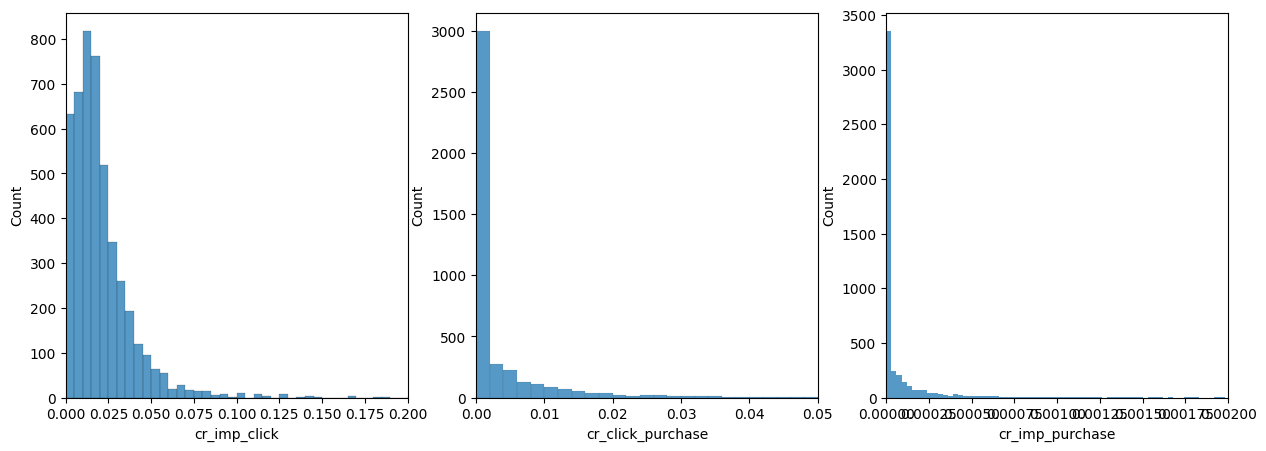

In [5]:
# plot the distributions of the conversion rates
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# sns.kdeplot(data=conv_rates, x="cr_imp_click", fill=True, ax=ax[0])
# sns.kdeplot(data=conv_rates, x="cr_click_purchase", fill=True, ax=ax[1])
# sns.kdeplot(data=conv_rates, x="cr_imp_purchase", fill=True, ax=ax[2])
sns.histplot(conv_rates['cr_imp_click'], ax=ax[0], binwidth=0.005)
sns.histplot(conv_rates['cr_click_purchase'], ax=ax[1], binwidth=0.002)
sns.histplot(conv_rates['cr_imp_purchase'], ax=ax[2], binwidth=0.00003)
ax[0].set_xlim(left=0.0, right=0.2)
ax[1].set_xlim(left= 0.0, right=0.05)
ax[2].set_xlim(left= 0.0, right=0.002)
plt.show()

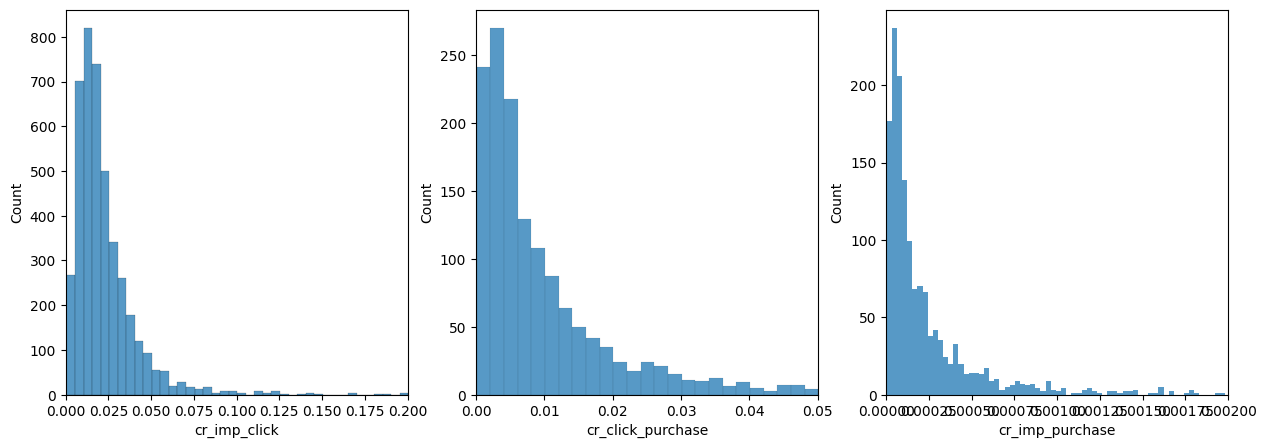

In [6]:
# exclude zero observations and plot the distributions of the conversion rates
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(conv_rates[conv_rates['cr_imp_click'] > 0]['cr_imp_click'], ax=ax[0], binwidth=0.005)
sns.histplot(conv_rates[conv_rates['cr_click_purchase'] > 0]['cr_click_purchase'], ax=ax[1], binwidth=0.002)
sns.histplot(conv_rates[conv_rates['cr_imp_purchase'] > 0]['cr_imp_purchase'], ax=ax[2], binwidth=0.00003)
ax[0].set_xlim(left=0.0, right=0.2)
ax[1].set_xlim(left= 0.0, right=0.05)
ax[2].set_xlim(left= 0.0, right=0.002)
plt.show()

<Axes: >

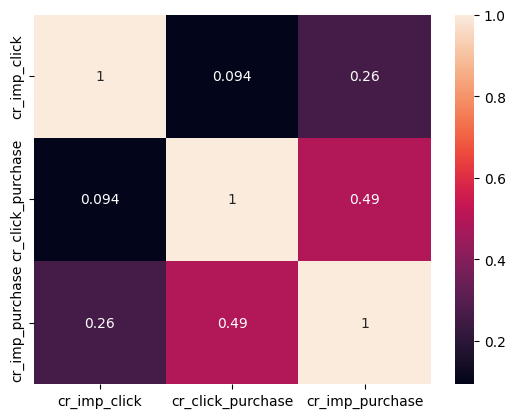

In [7]:
# correlate the conversion rates
conv_rates[['cr_imp_click', 'cr_click_purchase', 'cr_imp_purchase']].corr()
# plot the correlation matrix
sns.heatmap(conv_rates[['cr_imp_click', 'cr_click_purchase', 'cr_imp_purchase']].corr(), annot=True)

(0.0, 0.05)

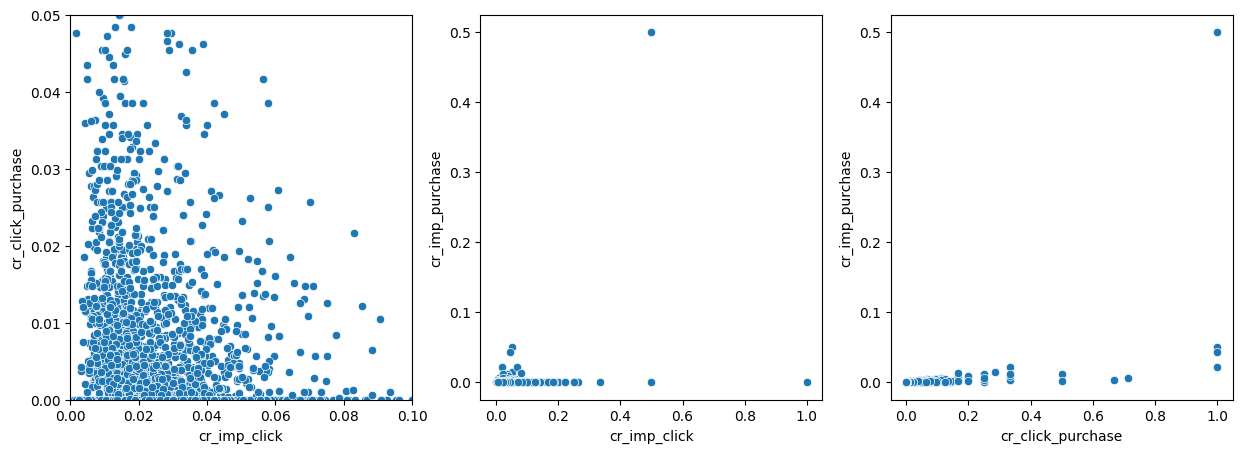

In [8]:
# make a scatter plot of the conversion rates
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=conv_rates, x='cr_imp_click', y='cr_click_purchase', ax=ax[0])
sns.scatterplot(data=conv_rates, x='cr_imp_click', y='cr_imp_purchase', ax=ax[1])
sns.scatterplot(data=conv_rates, x='cr_click_purchase', y='cr_imp_purchase', ax=ax[2])
ax[0].set_xlim(left=0.0, right=0.1)
ax[0].set_ylim(bottom=0.0, top=0.05)

In [9]:
sums = facebook.groupby('ad_id')[['impressions', 'clicks', 'purchases']].sum().reset_index()
sums

,ad_id,impressions,clicks,purchases
0,23849013860970589,6898,80,1
1,23849013861000589,3974,58,0
2,23849013861020589,32063,146,0
3,23849013861040589,4345,62,1
4,23849013959450589,32856,319,2
...,...,...,...,...
4705,120207871303800590,1588,4,0
4706,120207871312370590,12479,170,0
4707,120207874169950590,19266,460,0
4708,120207877286230590,8173,189,0


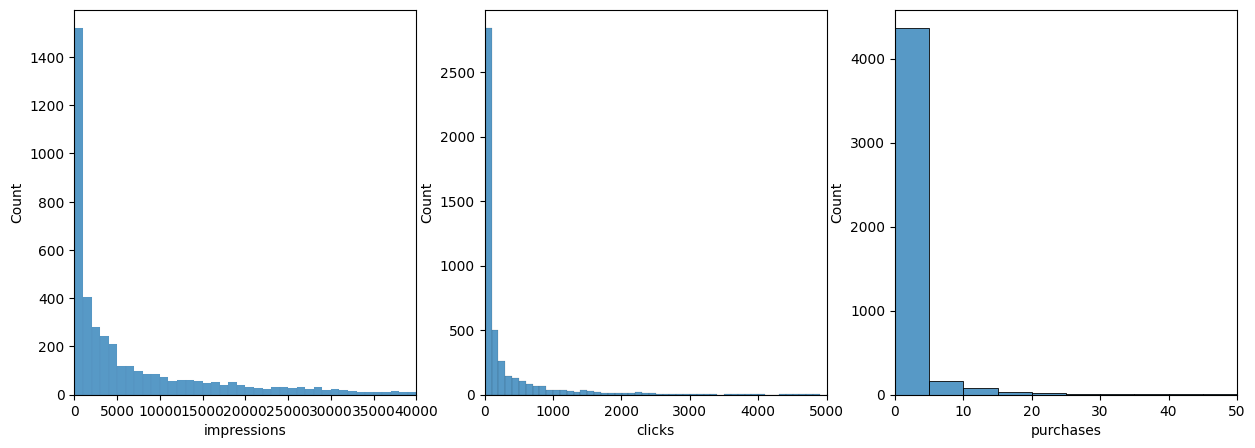

In [10]:
# plot histograms of the sums
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(sums['impressions'], ax=ax[0], binwidth=1000)
sns.histplot(sums['clicks'], ax=ax[1], binwidth=100)
sns.histplot(sums['purchases'], ax=ax[2], binwidth=5)
ax[0].set_xlim(left=0.0, right=4e4)
ax[1].set_xlim(left=0.0, right=5000)
ax[2].set_xlim(left=0.0, right=50)

plt.show()

In [11]:
# aggregate the sums over ad_id_days_since_first_seen
sums_delay = facebook.groupby(['ad_id_days_since_first_seen'])[['impressions', 'clicks', 'purchases']].sum().reset_index()
sums_delay

,ad_id_days_since_first_seen,impressions,clicks,purchases
0,0,7481694,174692,504
1,1,8519035,196322,682
2,2,7279797,153344,638
3,3,6838161,132552,637
4,4,5049800,93247,308
...,...,...,...,...
513,519,0,0,0
514,520,0,0,0
515,521,0,0,0
516,522,0,0,0


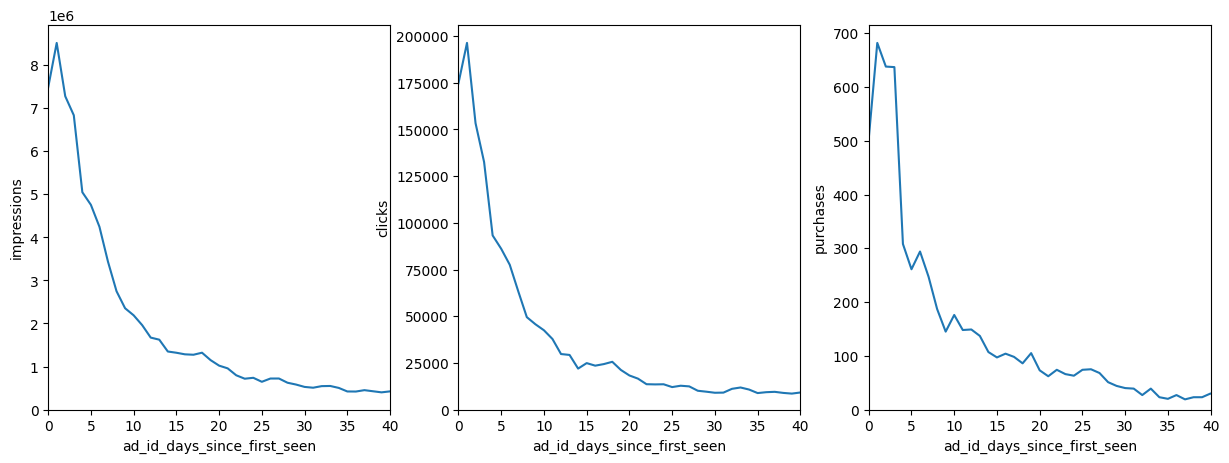

In [12]:
# plot the sums as a function of days since first seen
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(data=sums_delay, x='ad_id_days_since_first_seen', y='impressions', ax=ax[0])
sns.lineplot(data=sums_delay, x='ad_id_days_since_first_seen', y='clicks', ax=ax[1])
sns.lineplot(data=sums_delay, x='ad_id_days_since_first_seen', y='purchases', ax=ax[2])
ax[0].set_xlim(left=0.0, right=40)
ax[0].set_ylim(bottom=0.0)
ax[1].set_xlim(left=0.0, right=40)
ax[1].set_ylim(bottom=0.0)
ax[2].set_xlim(left=0.0, right=40)
ax[2].set_ylim(bottom=0.0)
plt.show()

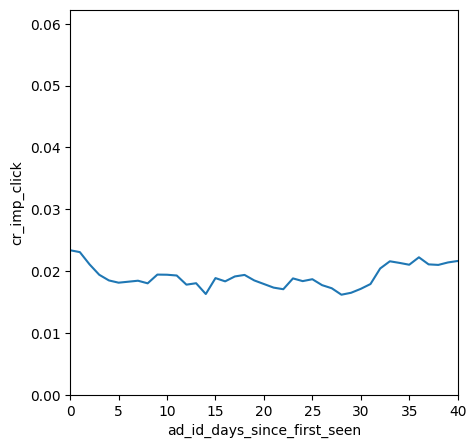

In [13]:
# calculate the conversion rates in the aggregated data
sums_delay['cr_imp_click'] = sums_delay['clicks'] / sums_delay['impressions']
# plot it
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.lineplot(data=sums_delay, x='ad_id_days_since_first_seen', y='cr_imp_click', ax=ax)
ax.set_xlim(left=0.0, right=40)
ax.set_ylim(bottom=0.0)
plt.show()

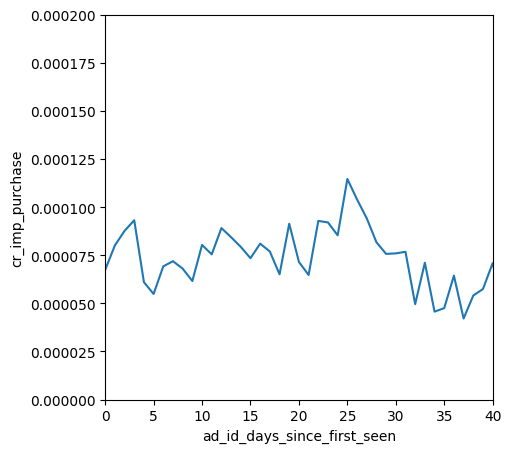

In [14]:
# same for impression to purchase conversion rate
sums_delay['cr_imp_purchase'] = sums_delay['purchases'] / sums_delay['impressions']
# plot it
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.lineplot(data=sums_delay, x='ad_id_days_since_first_seen', y='cr_imp_purchase', ax=ax)
ax.set_xlim(left=0.0, right=40)
ax.set_ylim(bottom=0.0, top=0.0002)
plt.show()

# Modeling - Impression to click

In [15]:
# find ad_ids in facebook that have days with xx > yy and slim down the data to only those ad_ids
ad_ids = facebook[facebook['impressions'] >= 0]['ad_id'].unique()
# take a randomized sample from ad_ids
np.random.seed(42)
ad_ids = np.random.choice(ad_ids, 50)
# only keep the rows with ad_ids in ad_ids
facebook_slimmed = facebook[facebook['ad_id'].isin(ad_ids)].copy()
ad_ids.shape, facebook_slimmed.shape
# ad_ids

((50,), (1565, 13))

In [16]:
# add an index to the slimmed data for the ad_ids in the slimmed ad_id set, to be able to use them in the model
facebook_slimmed['ad_id_index'] = facebook_slimmed['ad_id'].apply(lambda x: list(ad_ids).index(x))
facebook_slimmed.head()

,date,ad_id,spend,reach,impressions,clicks,purchases,purchases_value,roas,ctr,cost_per_purchase,ad_id_date_first,ad_id_days_since_first_seen,ad_id_index
158,2024-05-19,120204871062580590,0.01,3,3,0,0,0.0,0.0,0.000000,NaN,2024-03-13,67,8
217,2024-05-19,120206186155640590,0.02,4,4,0,0,0.0,0.0,0.000000,NaN,2024-04-17,32,25
269,2024-05-19,120206609586940590,0.08,15,15,0,0,0.0,0.0,0.000000,NaN,2024-05-03,16,41
383,2024-05-20,120204871062580590,0.37,29,36,0,0,0.0,0.0,0.000000,NaN,2024-03-13,68,8
602,2024-05-19,120206390360220590,0.42,72,84,3,0,0.0,0.0,0.035714,NaN,2024-05-03,16,3


In [17]:

with pm.Model(coords={"ad_id": ad_ids}) as model_imp_click:
    # data
    impressions = pm.Data('impressions', facebook_slimmed['impressions'])
    # index of the ad in the ad_ids array - used for indexing the ad_id specific parameters
    ad_id_idx = facebook_slimmed['ad_id'].apply(lambda x: list(ad_ids).index(x))
    
    # priors
    # general conversion rate
    cr_imp_click_hyper = pm.Normal('cr_imp_click_hyper', mu=0.02, sigma=0.02)
    cr_imp_click_sigma_hyper = pm.HalfNormal('cr_imp_click_sigma_hyper', sigma=0.02)

    # ad_id specific conversion rate drawn from the general conversion rate
    cr_imp_click = pm.Normal('cr_imp_click', mu=cr_imp_click_hyper, sigma=cr_imp_click_sigma_hyper, dims="ad_id")   
    
    # sigma for output likelihood
    sigma = pm.HalfNormal('sigma', sigma=0.02)

    # cr_imp_click[ad_id_idx] is the full vector of ad_id specific conversion rates for all observations
    mu = pm.Deterministic('mu', cr_imp_click[ad_id_idx] * impressions)
    
    # likelihood
    clicks = pm.Normal('clicks', mu=mu, sigma=sigma, observed=facebook_slimmed['clicks'])
    
    trace_imp_click = pm.sample(1000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [cr_imp_click_hyper, cr_imp_click_sigma_hyper, cr_imp_click, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


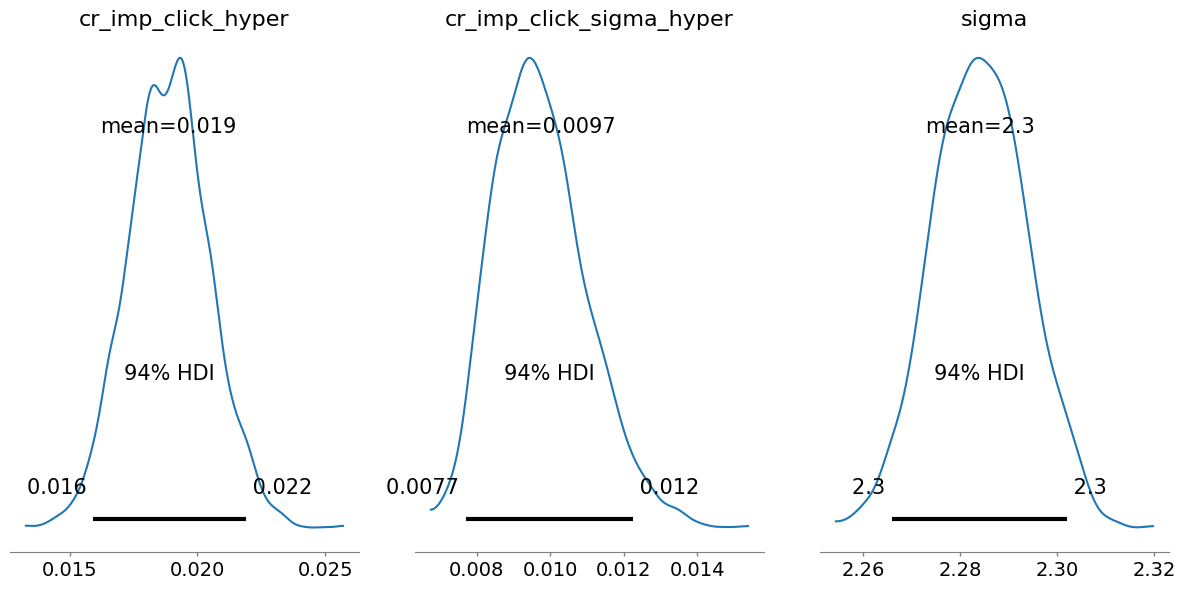

In [18]:
az.plot_posterior(
    trace_imp_click,
    var_names=['cr_imp_click_hyper', 'cr_imp_click_sigma_hyper','sigma'],
    figsize=(12, 6),
)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

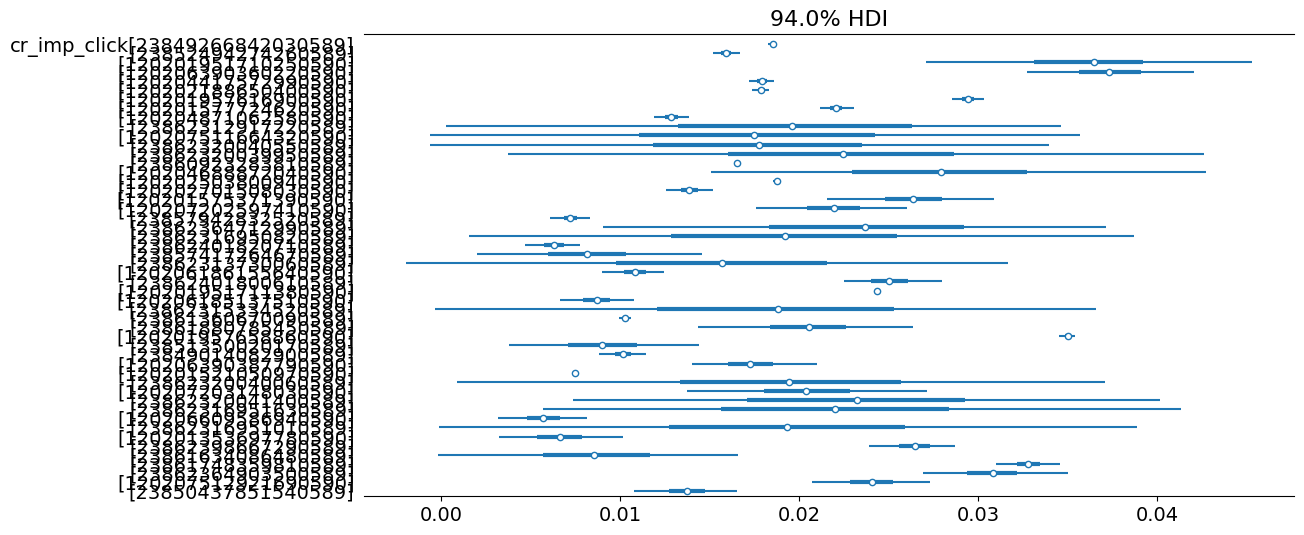

In [19]:
az.plot_forest(
    trace_imp_click,
    var_names=['cr_imp_click'],
    combined=True,
    figsize=(12, 6),
)

array([[<Axes: title={'center': 'cr_imp_click_hyper'}>,
        <Axes: title={'center': 'cr_imp_click_hyper'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'cr_imp_click'}>,
        <Axes: title={'center': 'cr_imp_click'}>]], dtype=object)

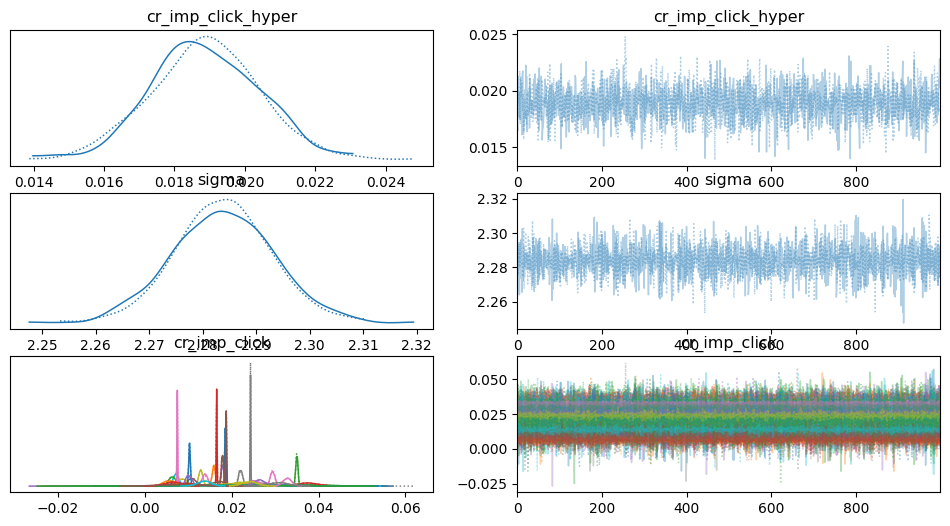

In [48]:
az.plot_trace(trace_imp_click, var_names=['cr_imp_click_hyper', 'sigma', 'cr_imp_click'])

# Model - purchases by way of modeled clicks

In [31]:
with pm.Model(coords={"ad_id": ad_ids}) as model_imp_purchase:
    # data
    impressions = pm.Data('impressions', facebook_slimmed['impressions'])
    
    # index of the ad in the ad_ids array - used for indexing the ad_id specific parameters
    ad_id_idx = facebook_slimmed['ad_id'].apply(lambda x: list(ad_ids).index(x))
    
    # priors
    cr_imp_click_hyper = pm.Normal('cr_imp_click_hyper', mu=0.02, sigma=0.02)
    # ad_id specific conversion rate
    cr_imp_click = pm.Normal('cr_imp_click', mu=cr_imp_click_hyper, sigma=0.02, dims="ad_id")   

    sigma_click = pm.HalfNormal('sigma_click', sigma=0.02)

    mu_click = pm.Deterministic('mu_click', cr_imp_click[ad_id_idx] * impressions)

    # likelihood
    clicks = pm.Normal('clicks', mu=mu_click, sigma=sigma_click, observed=facebook_slimmed['clicks'])

    cr_click_purchase_hyper = pm.Normal('cr_click_purchase_hyper', mu=0.02, sigma=0.02) 
    cr_click_purchase = pm.Normal('cr_click_purchase', mu=cr_click_purchase_hyper, sigma=0.02, dims="ad_id")   
    
    mu_purchase = pm.Deterministic('mu_purchase', cr_click_purchase[ad_id_idx] * clicks)

    sigma_purchase = pm.HalfNormal('sigma_purchase', sigma=0.02)

    purchase = pm.Normal('purchase', mu=mu_purchase, sigma=sigma_purchase, observed=facebook_slimmed['purchases'])
    
    
    trace_imp_purchase = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [cr_imp_click_hyper, cr_imp_click, sigma_click, cr_click_purchase_hyper, cr_click_purchase, sigma_purchase]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


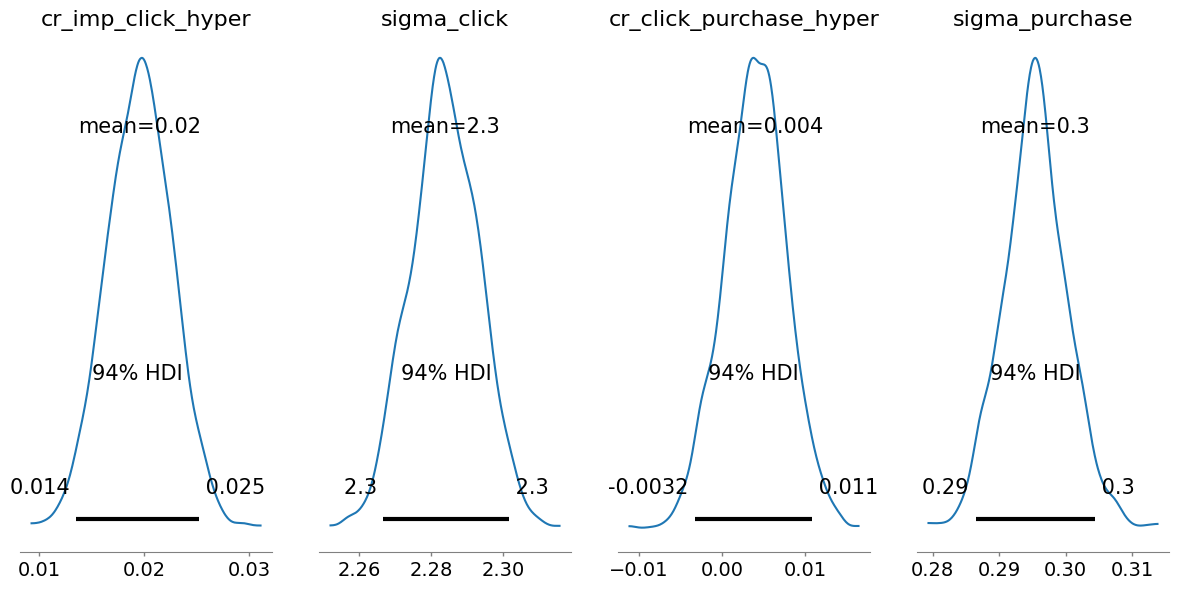

In [32]:
az.plot_posterior(
    trace_imp_purchase,
    var_names=['cr_imp_click_hyper', 'sigma_click', 'cr_click_purchase_hyper', 'sigma_purchase'],
    figsize=(12, 6),
)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

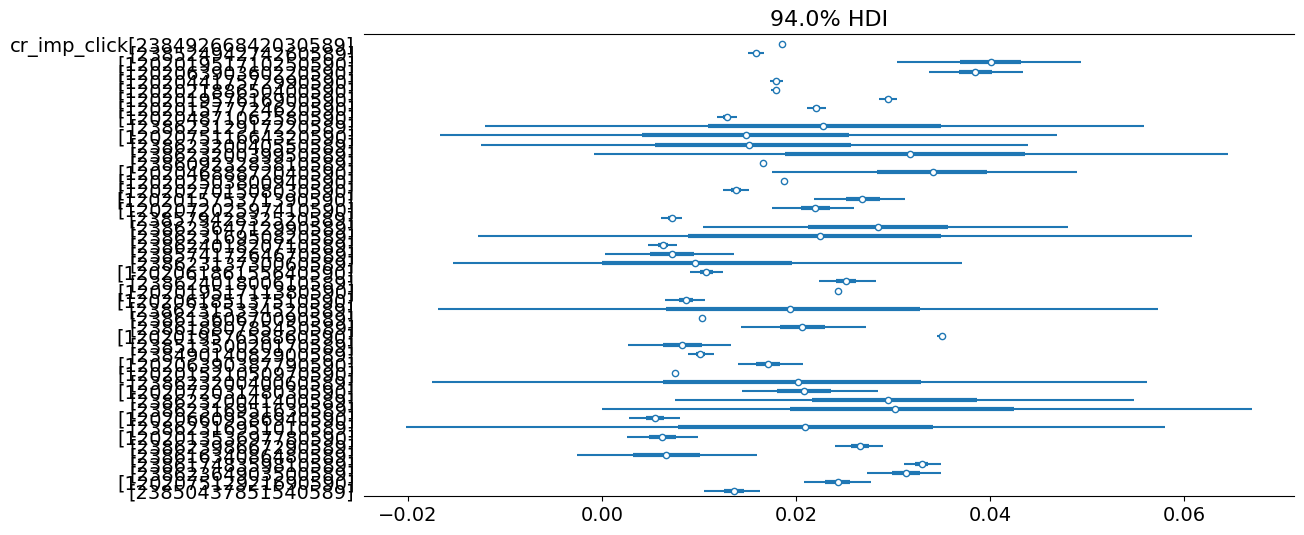

In [33]:
az.plot_forest(
    trace_imp_purchase,
    var_names=['cr_imp_click'],
    combined=True,
    figsize=(12, 6),
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

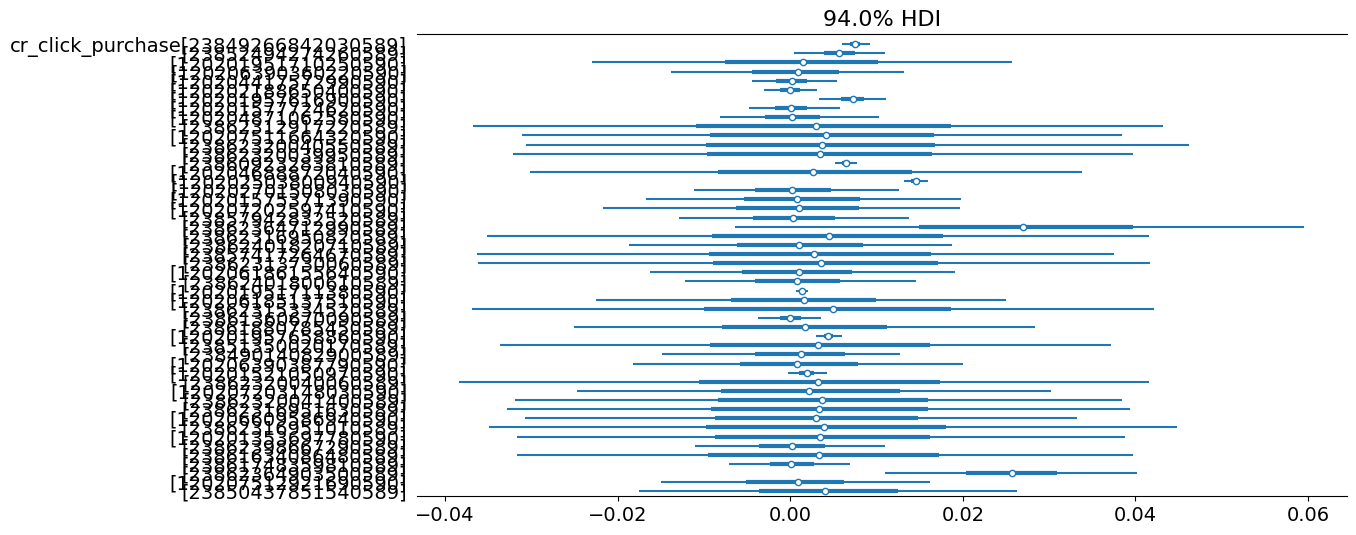

In [34]:
az.plot_forest(
    trace_imp_purchase,
    var_names=['cr_click_purchase'],
    combined=True,
    figsize=(12, 6),
)

array([[<Axes: title={'center': 'cr_imp_click_hyper'}>,
        <Axes: title={'center': 'cr_imp_click_hyper'}>],
       [<Axes: title={'center': 'sigma_click'}>,
        <Axes: title={'center': 'sigma_click'}>],
       [<Axes: title={'center': 'cr_imp_click'}>,
        <Axes: title={'center': 'cr_imp_click'}>]], dtype=object)

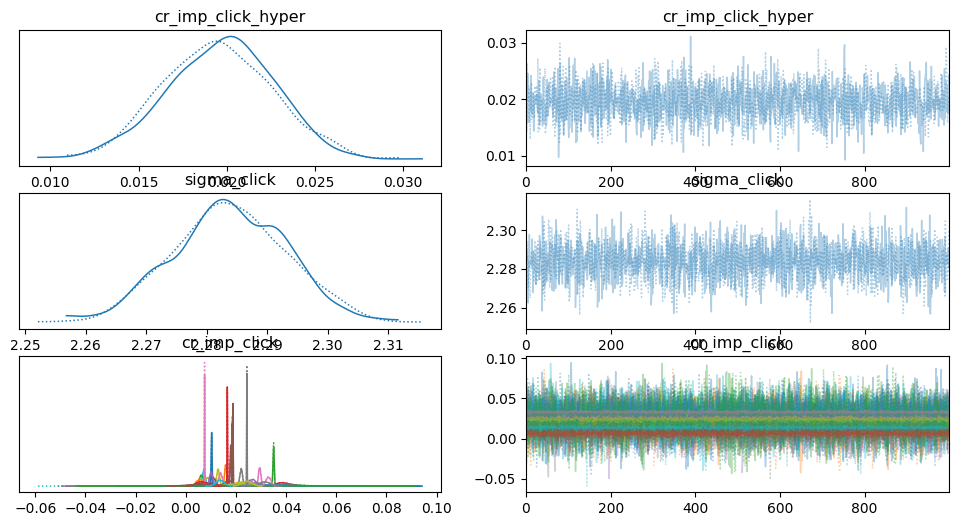

In [35]:
az.plot_trace(trace_imp_purchase, var_names=['cr_imp_click_hyper', 'sigma_click', 'cr_imp_click'])

array([[<Axes: title={'center': 'cr_click_purchase_hyper'}>,
        <Axes: title={'center': 'cr_click_purchase_hyper'}>],
       [<Axes: title={'center': 'sigma_purchase'}>,
        <Axes: title={'center': 'sigma_purchase'}>],
       [<Axes: title={'center': 'cr_click_purchase'}>,
        <Axes: title={'center': 'cr_click_purchase'}>]], dtype=object)

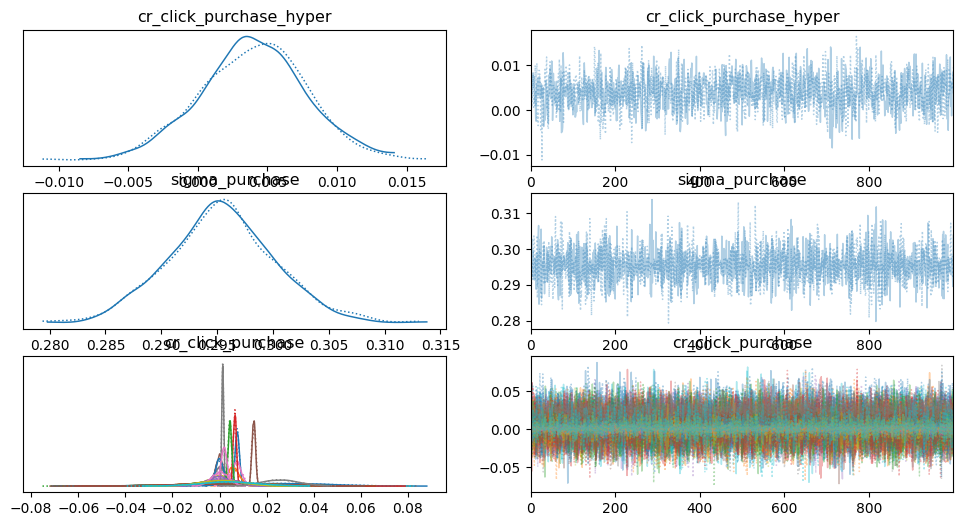

In [36]:
az.plot_trace(trace_imp_purchase, var_names=['cr_click_purchase_hyper', 'sigma_purchase', 'cr_click_purchase'])

In [37]:
trace_imp_purchase

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [38]:
trace_imp_purchase.posterior['cr_imp_click'].mean(dim=['chain', 'draw']).values.shape

(50,)

In [39]:
conv_rates = pd.DataFrame({
    'cr_imp_click': trace_imp_purchase.posterior['cr_imp_click'].mean(dim=['chain', 'draw']).values,
    'cr_click_purchase': trace_imp_purchase.posterior['cr_click_purchase'].mean(dim=['chain', 'draw']).values
})
conv_rates

,cr_imp_click,cr_click_purchase
0,0.018536,7.524387e-03
1,0.015902,5.669209e-03
2,0.040109,1.327290e-03
3,0.038478,7.374579e-04
4,0.017953,9.239499e-05
5,0.017895,5.238426e-08
6,0.029473,7.231278e-03
7,0.022097,6.617463e-05
8,0.012861,2.518817e-04
9,0.022789,3.663162e-03


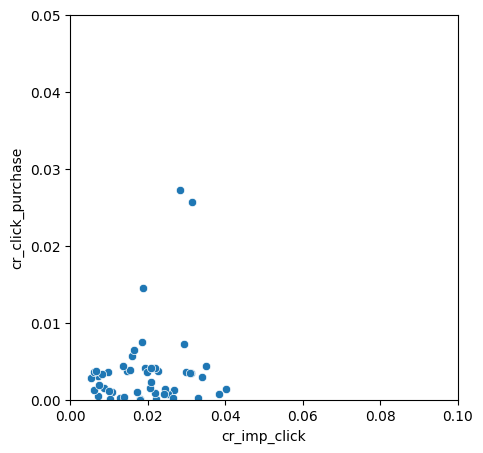

In [40]:
# scatter plot of the conversion rates
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=conv_rates, x='cr_imp_click', y='cr_click_purchase', ax=ax)
ax.set_xlim(left=0.0, right=0.1)
ax.set_ylim(bottom=0.0, top=0.05)
plt.show()

<Axes: >

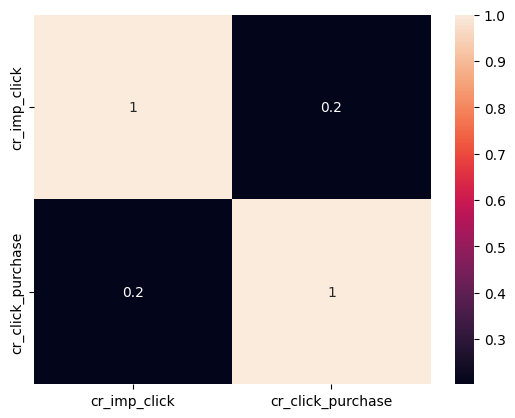

In [41]:
# correlation matrix of the conversion rates
conv_rates.corr()
# plot
sns.heatmap(conv_rates.corr(), annot=True)
